In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from CPD import datasets, loss, models
from CPD import new_metrics as metrics

%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
path_to_data = "data/mnist/"
dataset = datasets.MNISTSequenceDataset(path_to_data=path_to_data, type_seq="all", baseline=True)
train_dataset, test_dataset = datasets.CPDDatasets.train_test_split_(
    dataset, test_size=0.3, shuffle=True
)           

In [15]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return F.sigmoid(x)

In [16]:
class Baseline_model(pl.LightningModule):
    """Pytorch Lightning wrapper for change point detection models."""

    def __init__(
        self,
        model: nn.Module,
        train_dataset,
        test_dataset,
        lr: float = 1e-3,
        batch_size: int = 64,
        num_workers: int = 4,
    ) -> None:

        super().__init__()
        self.model = model

        self.lr = lr
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.loss = nn.BCELoss()

        self.train_dataset, self.test_dataset = train_dataset, test_dataset

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

    def training_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        inputs, labels = batch
        
        #if max(labels.unique()).item() > len(TARGETS) - 1:
        #    labels = idx2onehot(labels, len(TARGETS))
        
        pred = self.forward(inputs.float())              
        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = (
            ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
        )
        

        self.log("train_loss", train_loss, prog_bar=True)
        self.log("train_acc", train_accuracy, prog_bar=True)

        return train_loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        inputs, labels = batch
        
        #if max(labels.unique()).item() > len(TARGETS) - 1:
        #    labels = idx2onehot(labels, len(TARGETS))

        pred = self.forward(inputs.float())

        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        val_accuracy = (
            ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
        )

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_accuracy, prog_bar=True)

        return val_loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return opt

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [17]:
baseline_model_base = MNIST_Net()

baseline_model = Baseline_model(baseline_model_base, train_dataset, test_dataset, 
                                lr=0.001, batch_size=128)

In [18]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

experiment_name = 'mnist_baseline'
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

early_stop_callback = EarlyStopping(monitor="val_loss", 
                                    min_delta=0.00, patience=5, 
                                    verbose=True, mode="min")

from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    dirpath='saves',
    filename='{epoch}-{val_loss:.2f}-{val_acc:.2f}', 
    every_n_val_epochs=2)

trainer = pl.Trainer(
    max_epochs=50, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1,
    logger = logger, callbacks = [checkpoint_callback, early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [19]:
trainer.fit(baseline_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | MNIST_Net | 39.3 K
1 | loss  | BCELoss   | 0     
------------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.054


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.035


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [20]:

# input data parameters
SEQ_LEN = 64
IM_SIZE = 28

input_size = IM_SIZE * IM_SIZE
hidden_rnn = 100
rnn_n_layers = 2
linear_dims = [100]
rnn_dropout = 0.5
dropout = 0.5

base_model_cpd = models.MnistRNN(input_size, hidden_rnn, rnn_n_layers, 
                                 linear_dims, rnn_dropout=0.0, 
                                 dropout=0.5,  rnn_type='LSTM')


cpd_model = models.CPD_model(model=base_model_cpd, T=16,
                             loss_type='CPD', experiment_type='mnist', 
                             lr=0.001, batch_size=64)

In [21]:
threshold_number = 25
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [22]:
baseline_model.to('cuda')
(_, _, delay_list, fp_delay_list) = metrics.get_pareto_metrics_for_threshold(baseline_model, 
                                                                             cpd_model.test_dataloader(), 
                                                                             threshold_list, 
                                                                             device='cuda')

TP: 0, FP: 300, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 1, FP: 296, TN: 3, FN: 0, DELAY:0.0, FP_DELAY:5.993333333333333
TP: 2, FP: 295, TN: 3, FN: 0, DELAY:0.0, FP_DELAY:7.096666666666667
TP: 1, FP: 298, TN: 1, FN: 0, DELAY:0.0, FP_DELAY:7.71
TP: 5, FP: 289, TN: 6, FN: 0, DELAY:0.0, FP_DELAY:10.973333333333333
TP: 4, FP: 282, TN: 14, FN: 0, DELAY:0.0, FP_DELAY:13.513333333333334
TP: 7, FP: 270, TN: 23, FN: 0, DELAY:0.0, FP_DELAY:16.18
TP: 5, FP: 267, TN: 28, FN: 0, DELAY:0.0, FP_DELAY:19.09
TP: 11, FP: 253, TN: 36, FN: 0, DELAY:0.0033333333333333335, FP_DELAY:22.23
TP: 11, FP: 225, TN: 64, FN: 0, DELAY:0.0, FP_DELAY:28.07
TP: 14, FP: 203, TN: 83, FN: 0, DELAY:0.006666666666666667, FP_DELAY:32.126666666666665
TP: 21, FP: 164, TN: 115, FN: 0, DELAY:0.016666666666666666, FP_DELAY:37.89
TP: 37, FP: 145, TN: 118, FN: 0, DELAY:0.05333333333333334, FP_DELAY:40.25
TP: 100, FP: 49, TN: 151, FN: 0, DELAY:0.36333333333333334, FP_DELAY:45.22666666666667
TP: 121, FP: 28, TN: 151, FN: 0, DELAY:0.6

In [23]:
fp_delay_list_cpd = [0.0,
 7.6866666666666665,
 29.046666666666667,
 38.67,
 41.71333333333333,
 42.54,
 43.32666666666667,
 43.64666666666667,
 43.89333333333333,
 44.1,
 44.193333333333335,
 44.4,
 44.556666666666665,
 44.623333333333335,
 44.72,
 44.81333333333333,
 44.906666666666666,
 45.07666666666667,
 45.223333333333336,
 45.45,
 45.56666666666667,
 45.70666666666666,
 45.82,
 45.89666666666667,
 45.986666666666665,
 46.05,
 64.0]

In [24]:
delay_list_cpd = [0.0,
 0.0,
 0.02,
 0.056666666666666664,
 0.07,
 0.09,
 0.12,
 0.13,
 0.13666666666666666,
 0.15666666666666668,
 0.17666666666666667,
 0.19666666666666666,
 0.22,
 0.23666666666666666,
 0.2833333333333333,
 0.31666666666666665,
 0.3466666666666667,
 0.39666666666666667,
 0.48333333333333334,
 0.5633333333333334,
 0.68,
 0.8333333333333334,
 1.0266666666666666,
 1.2366666666666666,
 1.5566666666666666,
 1.9966666666666666,
 17.86]

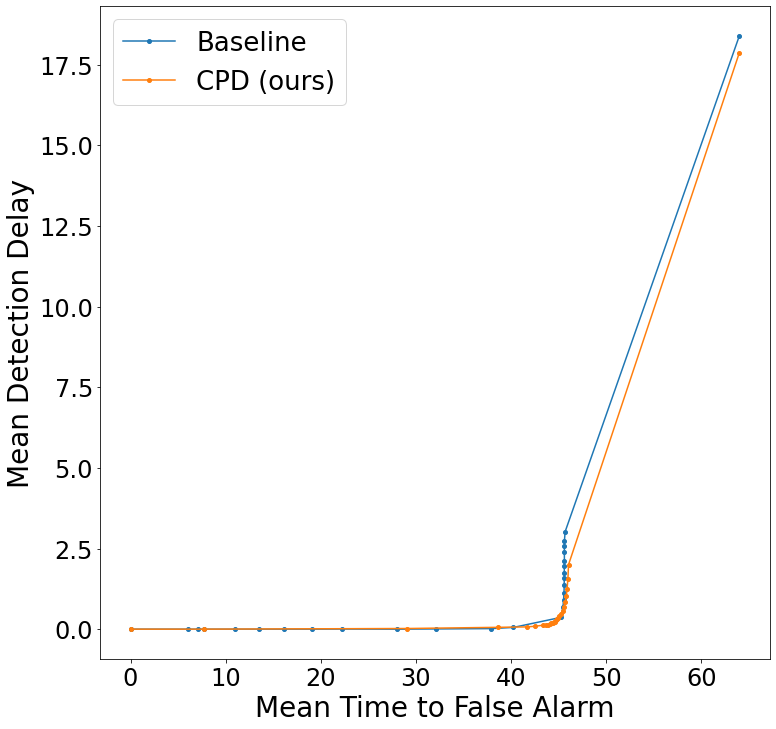

In [25]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', markersize=4, label='Baseline')
plt.plot(fp_delay_list_cpd, delay_list_cpd, '-o', markersize=4, label='CPD (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);

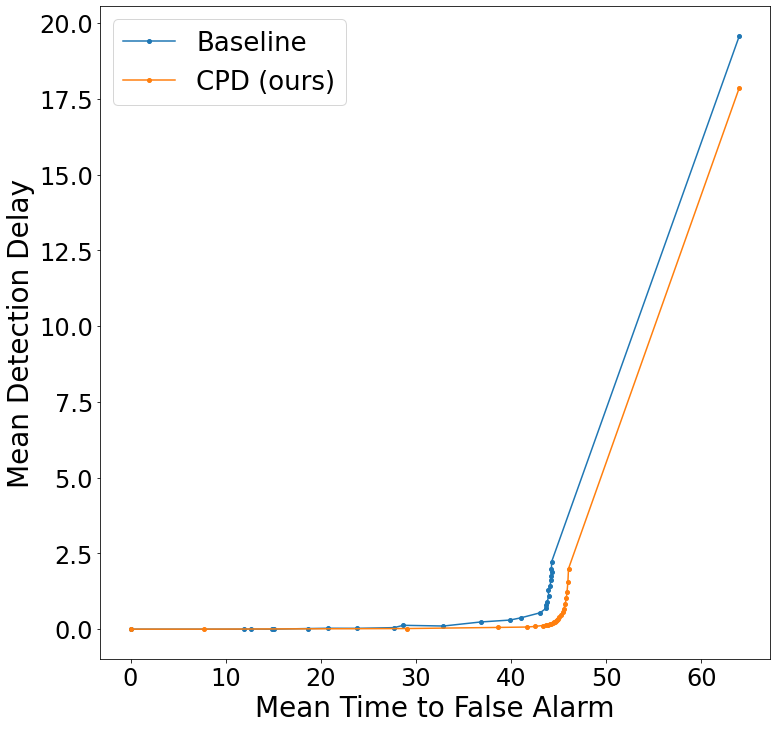

In [144]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', markersize=4, label='Baseline')
plt.plot(fp_delay_list_cpd, delay_list_cpd, '-o', markersize=4, label='CPD (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);

In [31]:
inp, lab = cpd_model.test_dataloader().dataset[-1]

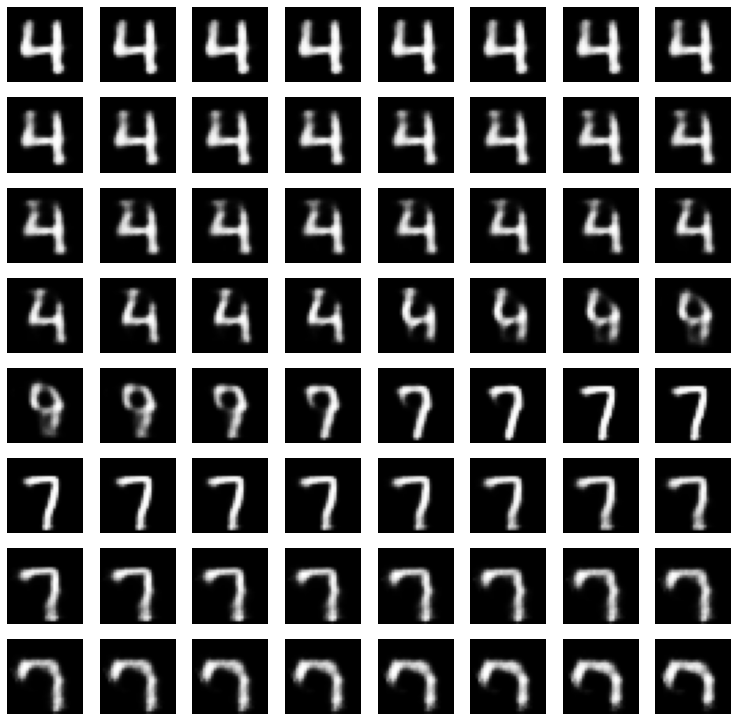

In [32]:
seq_len = 64
IM_SIZE = 28
full_image_sequence = torch.tensor(inp)
fig, axs = plt.subplots(8, 8, figsize=(13, 13))
# for ind in range(seq_len):
for index in range(seq_len):
    first_index = int(index / 8)
    second_index = index % 8
    axs[first_index, second_index].set_axis_off()
    axs[first_index, second_index].imshow(full_image_sequence[index].view(IM_SIZE, 
                                                                          IM_SIZE).detach().cpu().numpy(), cmap='gray')

In [33]:
full_image_sequence = full_image_sequence.to('cuda:1')
pred = baseline_model(full_image_sequence.float())

In [34]:
torch.where(pred == 1)[0]

tensor([36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56,
        59], device='cuda:1')

In [35]:
np.where(lab == 1)[0]

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [36]:
def evaluate_cpd(all_labels, all_preds):
    fp_number = 0
    fn_number = 0
    tp_number = 0
    tn_number = 0
    delay = []
    fp_delay = []

    for label, output in zip(all_labels, all_preds):
        output = torch.from_numpy(output)
        (
            tp_cur,
            tn_cur,
            fn_cur,
            fp_cur,
            delay_curr,
            fp_delay_curr,
        ) = metrics.evaluate_metrics(label, output, 0.5)

        tp_number += tp_cur
        fp_number += fp_cur
        tn_number += tn_cur
        fn_number += fn_cur

        delay.append(delay_curr)
        fp_delay.append(fp_delay_curr)
        
        confusion_matrix = (tp_number, fp_number, tn_number, fn_number)
    return confusion_matrix, np.mean(delay), np.mean(fp_delay)

In [39]:
inputs, labels = next(iter(cpd_model.val_dataloader()))

In [38]:
cpd_cover_dict = {}

baseline_model.to('cuda')
for th in threshold_list:
    cpd_cover_dict[th] = metrics.cover(baseline_model, cpd_model.val_dataloader(), th)

RuntimeError: mat1 dim 1 must match mat2 dim 0